## 4.1.6 재현 신경망(Recurrent Neural Network) 분류 모델

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import os
import json

from tqdm import tqdm

## 시각화

In [7]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## 학습 데이터 파일 로드

In [8]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [9]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = None

with open(DATA_IN_PATH + DATA_CONFIGS, 'r') as f:
    prepro_configs = json.load(f)

## 모델 정의

In [10]:
VOCAB_SIZE = prepro_configs['vocab_size']+1

WORD_EMBEDDING_DIM = 100
HIDDEN_STATE_DIM =150
DENSE_FEATURE_DIM = 150

BATCH_SIZE = 128
NUM_EPOCHS = 10
VALID_SPLIT = 0.1

In [11]:
print(len(prepro_configs['vocab']), VOCAB_SIZE) #check the number of vocab

74065 74066


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, WORD_EMBEDDING_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(HIDDEN_STATE_DIM, return_sequences=True),
    tf.keras.layers.LSTM(HIDDEN_STATE_DIM),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(DENSE_FEATURE_DIM, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         7406600   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 150)         150600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               22650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0

In [8]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback])

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 185s 8ms/sample - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6927 - val_accuracy: 0.5112
Epoch 2/10
22500/22500 [==============================] - 197s 9ms/sample - loss: 0.6901 - accuracy: 0.5088 - val_loss: 0.6131 - val_accuracy: 0.7516
Epoch 3/10
22500/22500 [==============================] - 210s 9ms/sample - loss: 0.3950 - accuracy: 0.8327 - val_loss: 0.2956 - val_accuracy: 0.8792
Epoch 4/10
22500/22500 [==============================] - 193s 9ms/sample - loss: 0.2140 - accuracy: 0.9220 - val_loss: 0.2758 - val_accuracy: 0.8908
Epoch 5/10
22500/22500 [==============================] - 187s 8ms/sample - loss: 0.1379 - accuracy: 0.9540 - val_loss: 0.3425 - val_accuracy: 0.8880


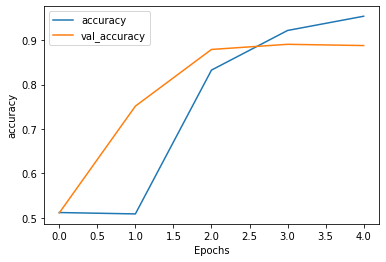

In [9]:
plot_graphs(history, 'accuracy')

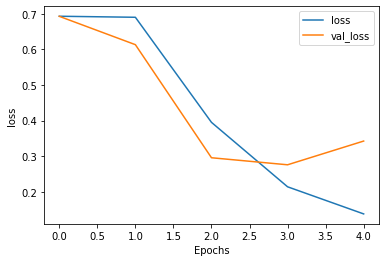

In [10]:
plot_graphs(history, 'loss')

## 모델 저장

In [14]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

model.save_weights(DATA_OUT_PATH + 'rnn_model.h5')

## 캐글 평가 데이터셋 만들기

In [11]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [15]:
model.load_weights(DATA_OUT_PATH + 'rnn_model.h5')

In [23]:
BLOCK_SIZE = 500

predictions = [model(test_input[i*BLOCK_SIZE:i*BLOCK_SIZE+BLOCK_SIZE]).numpy() \
               for i in tqdm(range(test_input.shape[0] // BLOCK_SIZE))]

100%|██████████| 50/50 [02:02<00:00,  2.44s/it]


In [25]:
predictions = np.concatenate(predictions, axis=-2).squeeze(-1)

In [27]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

In [28]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)} )
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3 )

### Kaggle 점수 확인

![alt text](images/rnn_classification_score.png "Title") 